# PROJECT BRIEF

Microsoft sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired you to help them better understand the movie industry.

Your team is charged with doing data analysis and creating a presentation that explores what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

# The Data

On the same MySQL instance from last week, in the schema `movies`, is some movie-related data from:
* Box Office Mojo
* IMDB
* Rotten Tomatoes
* TheMovieDB.org

# The Deliverables

There are three required deliverables for this project:

1. A well documented **Jupyter Notebook** containing any code you've written for this project and comments explaining it.
2. An organized **README.md** file in the GitHub repository that describes the contents of the repository. This file should be the source of information for navigating through the repository.
3. A Github repository containing all of the above files and any additional files worth includding
4. [OPTIONAL] A short **slide deck** (delivered as a PDF export) giving a high-level overview of your methodology and recommendations for non-technical stakeholders. If you do this, make sure to also add and commit this pdf of your non-technical presentation to your repository with a file name of presentation.pdf.

### Jupyter Notebook Must-Haves

For this project, your Jupyter Notebook should meet the following specifications:

#### Organization/Code Cleanliness

* The notebook should be well organized, easy to follow,  and code should be commented where appropriate.  
    * Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code.  All functions have [docstrings](https://numpydoc.readthedocs.io/en/latest/format.html) that act as professional-quality documentation
* The notebook is written for technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.

#### Visualizations & EDA

* Your project contains at least 4 meaningful data visualizations, with corresponding interpretations. All visualizations are well labeled with axes labels, a title, and a legend (when appropriate)  
* You pose at least 3 meaningful questions and answer them through EDA.  These questions should be well labeled and easy to identify inside the notebook.
    * **Level Up**: Each question is clearly answered with a visualization that makes the answer easy to understand.   
* Your notebook should contain 1 - 2 paragraphs briefly explaining your approach to this project.

# Our Questions To Answer

1. How has the popularity (reviews/ratings) of certain genres changed over time? Colm

2. Is there an optimal run time and does that vary by domestic vs. foreign? Josh

3. Who are the most succesful (movie ratings) writers, directors and producers? Josh

4. Is there a correlation between production budget and domestic/worldwide earnings?



In [1]:
#Import Packages and Connect To Database

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
%matplotlib inline

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')


In [2]:
# Get IMDB Title Basics Tables (contains title, start year, runtime, and genre for each title)
df_imdb_title_basics = pd.read_sql_query(""" SELECT *
                                            FROM imdb_title_basics
                                            ;""", con)

In [3]:
# Get IMDB Title Ratings Table (contains average user rating and number of votes for each title)
df_imdb_title_ratings = pd.read_sql_query(""" SELECT *
                                             FROM imdb_title_ratings
                                             ;""", con)

In [4]:
# Merged IMDB Title Basics and Rating Tables and clean up data
imdb_title_combined = pd.merge(df_imdb_title_basics, df_imdb_title_ratings, how='inner', on='tconst')

# Drop NaN rows in runtime and sort by start year
imdb_title_combined = imdb_title_combined.dropna(axis=0, subset=['runtime_minutes']).sort_values('start_year')

# Convert runtime to INT
imdb_title_combined['runtime_minutes'] = imdb_title_combined['runtime_minutes'].astype(int)

In [5]:
# Get The Movie Database (TMDB) Table (contains language, title, popularity, user vote counts for each title)
df_tmdb = pd.read_sql_query(""" SELECT *
                               FROM tmdb_movies
                               ;""", con)

#Convert TMDB release_date data to datetime 
df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'])

In [6]:
#Get Box Office Mojo (BOM) Table (contains foreign & domestic gross revenue figures)
df_bom = pd.read_sql_query(""" SELECT *
                              FROM bom_movie_gross
                              ;""", con)

# Create 'Worldwide Gross' Column
df_bom['foreign_gross'] = df_bom['foreign_gross'].fillna(0)
df_bom['worldwide_gross'] = df_bom['foreign_gross'] + df_bom['domestic_gross']

In [7]:
#Get TN Movie Budgets Table (contains production budget, gross revenues figures)
df_tn = pd.read_sql_query(""" SELECT *
                             FROM tn_movie_budgets
                             ;""", con)

In [9]:
# Change release date to datetime datatype
df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])

# Convert revenue gross and production budget columns from string to int
df_tn['worldwide_gross'] = df_tn['worldwide_gross'].str.split('$').map(lambda x: x[1].replace(',',''))
df_tn['worldwide_gross']= pd.to_numeric(df_tn['worldwide_gross'])

df_tn['production_budget'] = df_tn['production_budget'].str.split('$').map(lambda x: x[1].replace(',',''))
df_tn['production_budget']= pd.to_numeric(df_tn['production_budget'])

df_tn['domestic_gross'] = df_tn['domestic_gross'].str.split('$').map(lambda x: x[1].replace(',',''))
df_tn['domestic_gross']= pd.to_numeric(df_tn['domestic_gross'])

# Create foriegn gross column
df_tn['foreign_gross'] = df_tn['worldwide_gross'] - df_tn['domestic_gross']

In [11]:
# Get Rotten Tomatoes (RT) Movie Information Table (contains rating, genre, director, producer, currency, dvd date, and studio)
df_rt_movie_info= pd.read_sql_query(""" SELECT *
                                        FROM rt_movie_info
                                        ;""", con)

In [12]:
# Get RT Reviews Table (contains reviews, user ratings, and critic)
df_rt_reviews= pd.read_sql_query(""" SELECT *
                                     FROM rt_movie_info
                                     ;""", con)

In [13]:
# Combine RT databases (using "id" as the primary key)
df_rt_combined = pd.merge(df_rt_movie_info,df_rt_reviews,how='inner',on='id')

In [14]:
#Clean runtime data in combined RT database
df_rt_combined['runtime'] = df_rt_combined['runtime_y'].str.split(" ").map(lambda x: x[0])
df_rt_combined['runtime'] = pd.to_numeric(df_rt_combined['runtime'])

In [15]:
# Get RT_IMDB link database (supposed to connect both tables by id)
df_rt_imdb= pd.read_sql_query(""" SELECT *
                                  FROM rt_imdb_link
                                  ;""", con)

# Question 1 - How does genre impact movie success?

In [ ]:
df_imdb_tmdb= pd.read_sql_query("""
SELECT *
FROM tmdb_imdb_link
;""", con)

df_imdb_tmdb

In [ ]:
#Clean IMDB IDs

imdb_title_combined['tconst'] = imdb_title_combined['tconst'].str.lstrip('tt')

imdb_title_combined = imdb_title_combined.rename(columns={'tconst': 'imdb_id'})

imdb_title_combined['imdb_id'] = imdb_title_combined['imdb_id'].astype(int)

#Clean TMDB IDs

df_tmdb = df_tmdb.rename(columns={'id': 'tmdb_id'})

#Merge

connected_imdb_tmdb = pd.merge(imdb_title_combined, df_imdb_tmdb, how='inner', on='imdb_id')

master_imdb_tmdb = pd.merge(connected_imdb_tmdb, df_tmdb, how='inner', on='tmdb_id')

master_imdb_tmdb = master_imdb_tmdb.rename(columns={'averagerating': 'averagerating_imdb', 'vote_average': 'vote_average_tmdb'})

master_imdb_tmdb

In [ ]:
master_imdb_tmdb = master_imdb_tmdb.rename_axis('master_id')



In [ ]:
full_list = master_imdb_tmdb['genres'].str.split(',').apply(frozenset).to_frame(name='genres')
for genres in frozenset.union(*full_list.genres):
    full_list[genres] = full_list.apply(lambda _: int(genres in _.genres), axis=1)
full_list

In [ ]:
master_imdb_tmdb = pd.merge(master_imdb_tmdb, full_list,how='left', on='master_id')

In [ ]:
genre_names = full_list.columns
genre_names = list(genre_names[2:26])

genre_names_df = pd.DataFrame(genre_names)
genre_names_df = genre_names_df.rename(columns={0: 'genre_name'})


In [ ]:
#IMDB AVERAGES

genre_imdbscore_averages = []

for i in genre_names:
    holder = master_imdb_tmdb.loc[master_imdb_tmdb[i] == 1]
    genre_imdbscore_averages.append(holder['averagerating_imdb'].mean())

genre_imdbscore_average_df = pd.DataFrame(genre_imdbscore_averages)
genre_imdbscore_average_df = genre_imdbscore_average_df.rename(columns={0: 'averagerating_imdb'})
genre_combined_df = pd.merge(genre_names_df,genre_imdbscore_average_df,left_index=True,right_index=True).sort_values('averagerating_imdb')

In [ ]:
f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.color_palette("YlGnBu", 10)
sns.barplot(genre_combined_df['averagerating_imdb'],genre_combined_df['genre_name'], palette='YlGnBu')
ax.set(xlabel='Average IMDB Rating', ylabel='Genre')

In [ ]:
#POPULARITY SCORE

genre_popularity_averages = []

for i in genre_names:
    holder = master_imdb_tmdb.loc[master_imdb_tmdb[i] == 1]
    genre_popularity_averages.append(holder['popularity'].mean())

genre_popularity_averages_df = pd.DataFrame(genre_popularity_averages)
genre_popularity_averages_df = genre_popularity_averages_df.rename(columns={0: 'average_popularity'})
genre_combined_df = pd.merge(genre_combined_df,genre_popularity_averages_df,left_index=True,right_index=True).sort_values('average_popularity')
genre_combined_df


In [ ]:
f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(genre_combined_df['average_popularity'],genre_combined_df['genre_name'], palette='YlGnBu')
ax.set(xlabel='Average TMDB Popularity Rating')




In [ ]:
f, ax1 = plt.subplots(figsize=(15,11))
ax1 = sns.barplot(x='genre_name',y='average_popularity',data=genre_combined_df, palette='YlGnBu')
ax1.set(ylabel='Average TMDB Popularity Rating', xlabel='Genres')
ax1.set_ylabel('Average TMDB Popularity Rating', color='tab:blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_ylim(bottom=0,top=11)

ax2 = ax1.twinx()
ax2 = sns.lineplot(x='genre_name', y='averagerating_imdb', data = genre_combined_df, color='tab:red')
ax2.set_ylabel('Average IMDB Rating', color='tab:red')
ax2.set_ylim(bottom=0,top=11)
plt.show()


In [ ]:
sns.lmplot('worldwide_gross','averagerating_imdb', test_combo)

In [ ]:
sns.lmplot('worldwide_gross','popularity', test_combo)

In [ ]:
genre_runtime_average = []

for i in genre_names:
    holder = master_imdb_tmdb.loc[master_imdb_tmdb[i] == 1]
    genre_runtime_average.append(holder['runtime_minutes'].median())

genre_runtime_average_df = pd.DataFrame(genre_runtime_average)
genre_runtime_average_df = genre_runtime_average_df.rename(columns={0: 'average_runtime'})

genre_combined_df = pd.merge(genre_combined_df,genre_runtime_average_df,left_index=True,right_index=True).sort_values('average_runtime')



In [ ]:
genre_combined_df_subset = genre_combined_df.loc[
(genre_combined_df['genre_name']=='Sci-Fi') |
(genre_combined_df['genre_name']=='Western')
]

In [ ]:
f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(genre_combined_df_subset['average_runtime'],genre_combined_df_subset['genre_name'], palette='YlGnBu')
ax.set(xlabel='Median Runtime', ylabel='Genre')



# QUESTION 2: ?

[Text(0.5, 0, 'Top 10 Studios by Gross')]

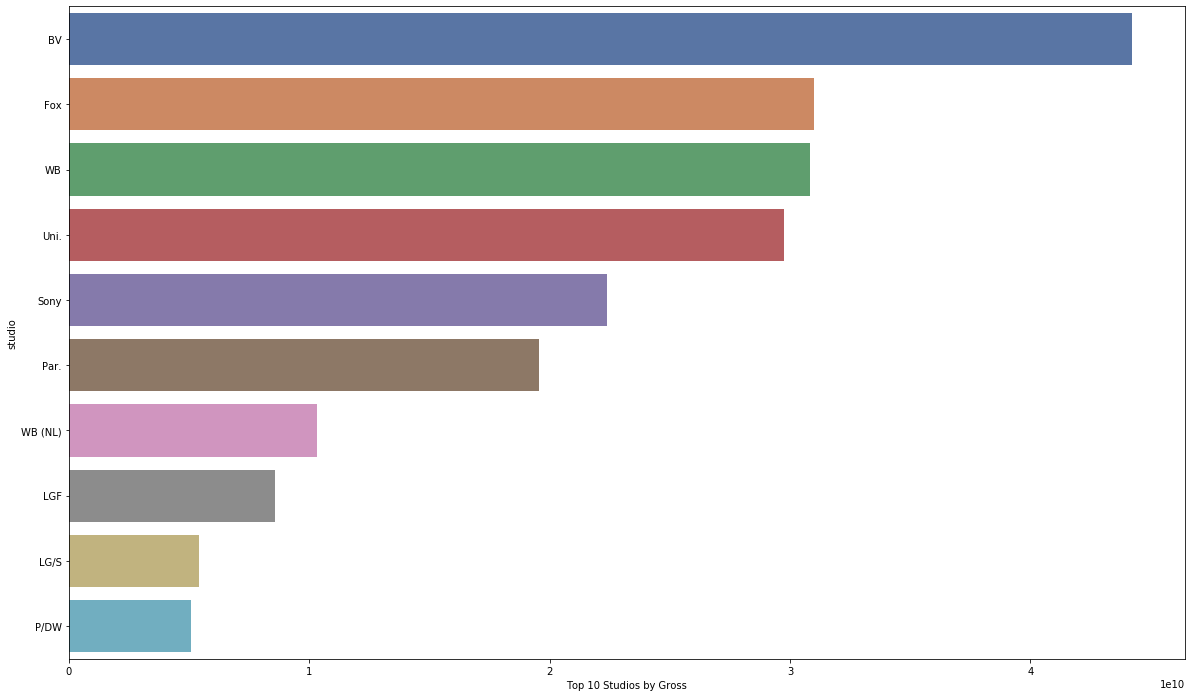

In [16]:
# Create a graph that sums the worldwide box office revenues by the Top 10 studios
bom_studio = df_bom.groupby('studio').sum().sort_values('worldwide_gross',ascending=False).head(10)

f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(bom_studio['worldwide_gross'],bom_studio.index, palette='deep')
ax.set(xlabel='Top 10 Studios by Gross')

In [17]:
# Create a 'year' column by pulling the year from the release date
df_tn['year'] = df_tn['release_date'].dt.to_period('Y')

# Create a 'last_five_years' column by seeing if the movie was created after 2014
df_tn['last_five_years'] = df_tn['year'].apply(lambda x:'yes' if int(x.strftime('%Y'))>2014 else 'no')

[Text(0.5, 0, 'Top 20 movies by Worldwide Gross')]

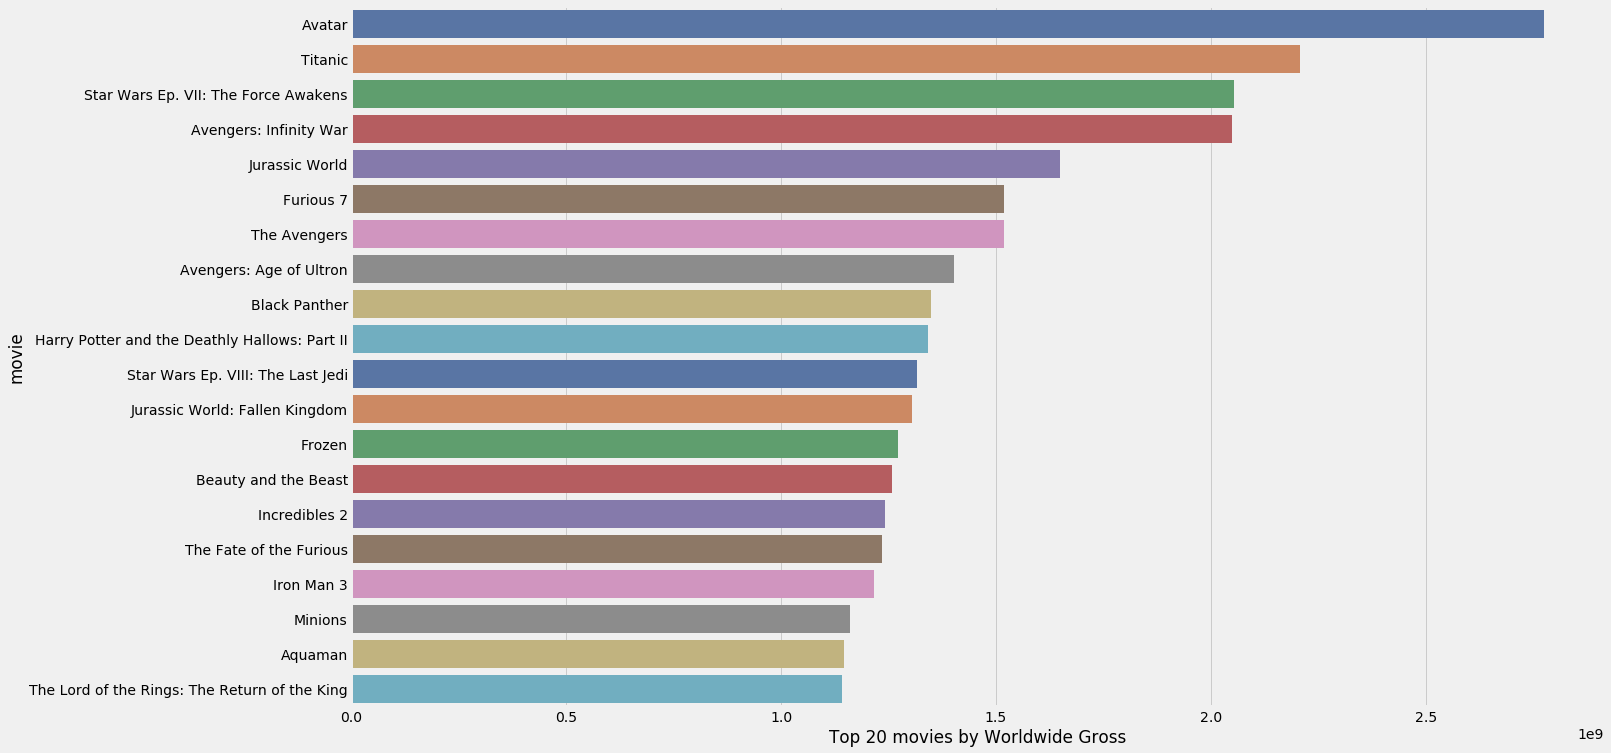

In [18]:
# Create a graph that shows the top 20 movies by Worldwide Gross
graph_tn = df_tn.sort_values('worldwide_gross',ascending=False).head(20)

f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(graph_tn['worldwide_gross'],graph_tn['movie'], palette='deep')
ax.set(xlabel='Top 20 movies by Worldwide Gross')


[Text(0.5, 0, 'Top 20 movies by Foreign Gross')]

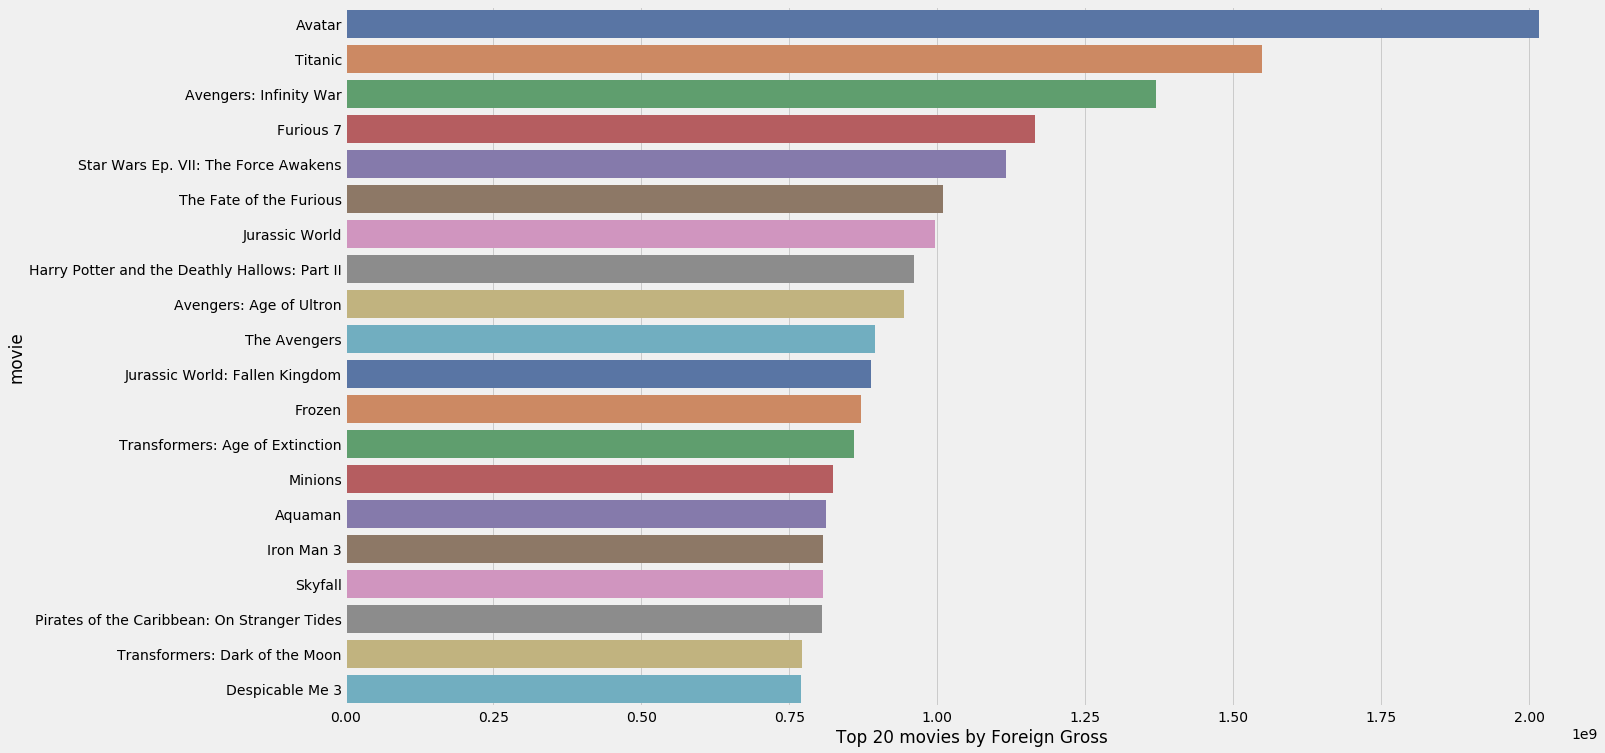

In [19]:
# Create a graph that shows the top 20 movies by Foreign Gross
graph_tn = df_tn.sort_values('foreign_gross',ascending=False).head(20)

f, ax = plt.subplots(figsize=(20,12))
plt.style.use('fivethirtyeight')
sns.barplot(graph_tn['foreign_gross'],graph_tn['movie'], palette='deep')
ax.set(xlabel='Top 20 movies by Foreign Gross')


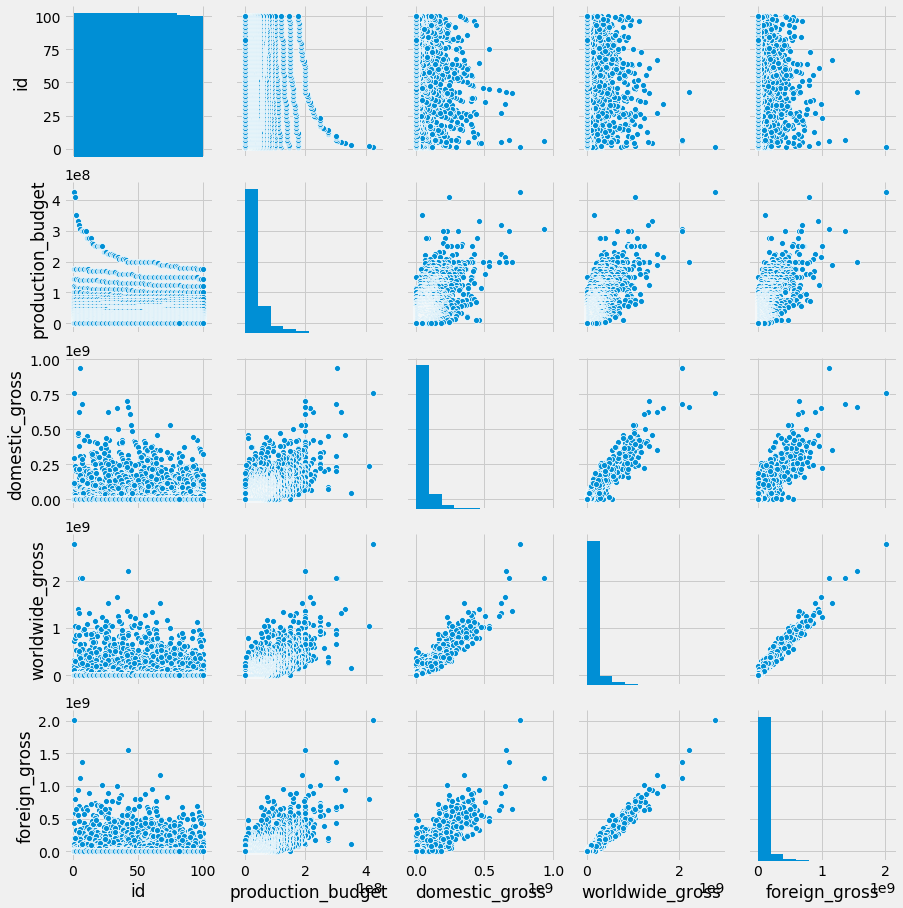

In [20]:
# Create a pairplot of the Table TN to see what relationships exist between production budget and gross revenue
sns.pairplot(df_tn)

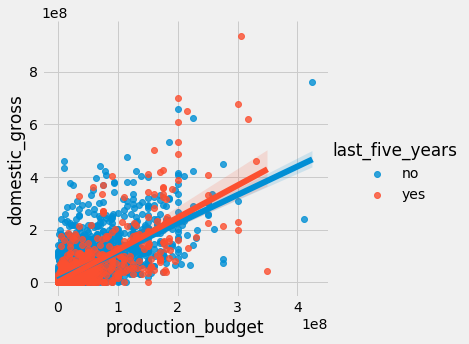

In [22]:
# Run a linear regression between production budget and domestic gross over the last 5 years
sns.lmplot('production_budget','domestic_gross', hue = 'last_five_years', data = df_tn)

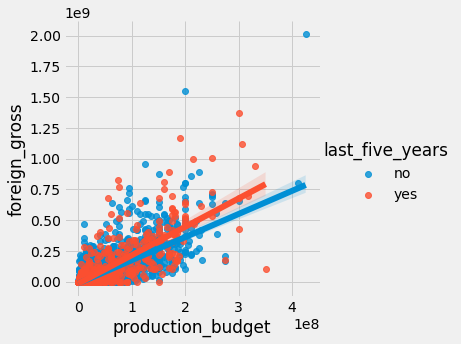

In [23]:
# Run a linear regression between production budget and foreign gross over the last 5 years
sns.lmplot('production_budget','foreign_gross', hue = 'last_five_years', data = df_tn)

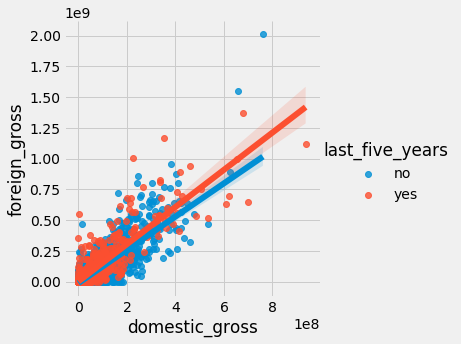

In [24]:
# Run a linear regression between domestic gross and foreign gross over the last 5 years
sns.lmplot('domestic_gross','foreign_gross',hue = 'last_five_years', data = df_tn)

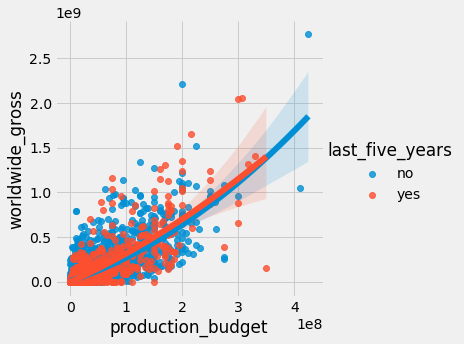

In [25]:
# Run a parabolic regression of prodution budget and worldwide_gross
sns.lmplot('production_budget','worldwide_gross', hue = 'last_five_years',order =2, ci = 95, data = df_tn)

# QUESTION 3: HOW DO DIFFERENT PEOPLE IMPACT THE MOVIE SUCCESS?

In [ ]:
# People Cleaning

df_imdb_name_basics= pd.read_sql_query("""
SELECT *
FROM imdb_name_basics
;""", con)

df_imdb_name_basics

In [ ]:
#Clean Known_For Column
known_for = df_imdb_name_basics['known_for_titles'].str.split(',tt')
known_for = df_imdb_name_basics['known_for_titles'].str.replace('tt','')
known_for = known_for.str.split(',')

In [ ]:
#Set Up Master Dictionary
master_dict = master_imdb_tmdb[['imdb_id','primary_title']].set_index('imdb_id').to_dict()['primary_title']


In [ ]:
#Insert Cleaned Column
df_imdb_name_basics['known_for_titles_cleaned'] = known_for

In [ ]:
#Loop Through Column and Assign Movie Names

empty_list = []

for row in df_imdb_name_basics['known_for_titles_cleaned']:
    empty_row = []
    for object in row:
        if object.isdigit():
            if int(object) in master_dict.keys():
                xyz = master_dict[int(object)]
                empty_row.append(xyz)
    empty_list.append(empty_row)

featured_movies = pd.DataFrame(empty_list,columns=['1st_movie','2nd_movie','3rd_movie','4th_movie'])


In [ ]:
#Merge Back Into Main Table

df_imdb_name_basics = pd.merge(df_imdb_name_basics,featured_movies,left_index=True,right_index=True)


In [ ]:
#Unpack Primary_Profession - CAREFUL, TAKES FOREVER TO RUN
full_profession = df_imdb_name_basics['primary_profession'].str.split(',').apply(frozenset).to_frame(name='primary_profession')
for profession in frozenset.union(*full_profession.primary_profession):
    full_profession[profession] = full_profession.apply(lambda _: int(profession in _.primary_profession), axis=1)
full_profession

In [ ]:
#Combine Back Into Main Table

df_imdb_name_basics = pd.merge(df_imdb_name_basics,full_profession,left_index=True,right_index=True)


In [ ]:
#Table Check
df_imdb_name_basics.loc[df_imdb_name_basics['primary_name']=='Idris Elba']

In [ ]:
#Add Popularity for 1st,2nd,3rd,4th Movies

popularity_dict = master_imdb_tmdb[['imdb_id','popularity']].set_index('imdb_id').to_dict()['popularity']

empty_list = []

for row in df_imdb_name_basics['known_for_titles_cleaned']:
    empty_row = []
    for object in row:
        if object.isdigit():
            if int(object) in master_dict.keys():
                xyz = popularity_dict[int(object)]
                empty_row.append(xyz)
    empty_list.append(empty_row)

featured_movies_popularity = pd.DataFrame(empty_list,columns=['1st_movie_popularity','2nd_popularity','3rd_popularity','4th_popularity'])

featured_movies_popularity

In [ ]:
featured_movies_popularity['1st_movie_popularity'].value_counts()

In [ ]:
#Merge Popularity Into Main Table

df_imdb_name_basics = pd.merge(df_imdb_name_basics,featured_movies_popularity,left_index=True,right_index=True)

In [ ]:
#Drop Rows Where We Have No Movie Match

df_imdb_name_basics = df_imdb_name_basics.dropna(subset=['1st_movie','2nd_movie','3rd_movie','4th_movie'],how='all')